In [27]:
import torch
import torch.nn as nn
import torchvision as tv
import torch.nn.functional as F

import numpy as np

import tkinter
import matplotlib
import matplotlib.pyplot as plt

import cv2
import os


from tqdm import tqdm
import math

In [28]:
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=4YVJK2DT3CT4CBQQSY6L
%env CLEARML_API_SECRET_KEY=5hyFEfqGpQyjGE0H6sZ9X9d7cpeJJvX5Q07vUbSMz16fBbdNGH
from clearml import Task, Dataset
task = Task.init(project_name='pytorch CNN', task_name='pythorch CNN research', output_uri = True)

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=4YVJK2DT3CT4CBQQSY6L
env: CLEARML_API_SECRET_KEY=5hyFEfqGpQyjGE0H6sZ9X9d7cpeJJvX5Q07vUbSMz16fBbdNGH


In [29]:
trans = tv.transforms.Compose([
    tv.transforms.ToTensor()
])

In [30]:
ds_mnist = tv.datasets.MNIST('./dataset', download = True, transform = trans)

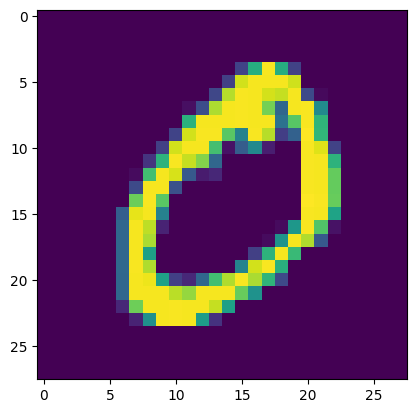

In [31]:
ds_mnist[0][0].shape
plt.imshow(ds_mnist[1][0].numpy()[0])

In [32]:
data = {"batch_size":16, "epochs":5, "1st layer neurons":32, "2nd layer neurons":64, "1st layer kernel":3, "2nd layer kernel":3}
task.connect(data)

dataloader = torch.utils.data.DataLoader(ds_mnist, batch_size = data["batch_size"], shuffle = True)

In [33]:
for img, label in dataloader:
    print(img.shape)
    print(label.shape)
    break

torch.Size([16, 1, 28, 28])
torch.Size([16])


In [34]:
def calculate_output_size(kernel_size, input_size, padding, stride):
    return ((input_size - kernel_size + 2 * padding) // stride) + 1

class Numbers(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, data["1st layer neurons"], kernel_size=data["1st layer kernel"], stride=1, padding=1)
        self.conv2 = nn.Conv2d(data["1st layer neurons"],data["2nd layer neurons"], kernel_size=data["2nd layer kernel"], stride=1, padding=1)
        
        output_size1 = calculate_output_size(data["1st layer kernel"], input_size=28, padding=1, stride=1)
        print(output_size1)
        output_size2 = calculate_output_size(data["2nd layer kernel"], input_size=output_size1, padding=1, stride=1)
        print(output_size2)

        dim =math.ceil( (output_size2 - data["2nd layer kernel"] + 1)/2 /2)
        print(dim)
        self.fc1 = nn.Linear(data["2nd layer neurons"] * dim * dim, 128)
        self.fc2 = nn.Linear(128, 10)
        
       # self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
       # self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
       # self.fc1 = nn.Linear(64 * 7 * 7, 128)
       # self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        

In [35]:
model = Numbers()

28
28
7


In [36]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

421642

In [37]:
loss_fn = nn.CrossEntropyLoss()

In [38]:
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3, momentum = 0.9)

In [39]:
def accuracy(pred, label):
    answer = F.softmax(pred.detach(), dim=1).numpy().argmax(1) == label.numpy().argmax(1)
    return answer.mean()

In [40]:
loss_values = []
accuracy_values = []

for epoch in range(data["epochs"]):
    loss_val = 0 
    acc_val = 0
    for img, label in (pbar :=  tqdm(dataloader)):
        optimizer.zero_grad()
        pred = model(img)
    
        label = nn.functional.one_hot(label, 10).float()
        
        loss = loss_fn(pred, label)
        loss.backward()
        loss_item = loss.item()
        loss_val += loss_item

        acc_current = accuracy(pred,label)
        acc_val += acc_current
        
        optimizer.step()

        pbar.set_description(f' epoch : {epoch}\t loss: {loss_item:.5f}\t accuracy: {acc_current:.3f}')

    loss_values.append(loss_val/len(dataloader))
    accuracy_values.append(acc_val/len(dataloader))

    
    print(f" mid loss : {loss_val/len(dataloader):.5f}")
    print(f" accuracy : {acc_val/len(dataloader):.5f}")

 epoch : 0	 loss: 0.07453	 accuracy: 1.000: 100%|██████████████████████████████████| 3750/3750 [01:58<00:00, 31.75it/s]


 mid loss : 0.41396
 accuracy : 0.87103


 epoch : 1	 loss: 0.05620	 accuracy: 1.000: 100%|██████████████████████████████████| 3750/3750 [02:03<00:00, 30.47it/s]


 mid loss : 0.11299
 accuracy : 0.96612


 epoch : 2	 loss: 0.03039	 accuracy: 1.000: 100%|██████████████████████████████████| 3750/3750 [02:00<00:00, 31.17it/s]


 mid loss : 0.07519
 accuracy : 0.97693


 epoch : 3	 loss: 0.01251	 accuracy: 1.000: 100%|██████████████████████████████████| 3750/3750 [01:56<00:00, 32.15it/s]


 mid loss : 0.05819
 accuracy : 0.98177


 epoch : 4	 loss: 0.02044	 accuracy: 1.000: 100%|██████████████████████████████████| 3750/3750 [01:39<00:00, 37.79it/s]

 mid loss : 0.04838
 accuracy : 0.98503


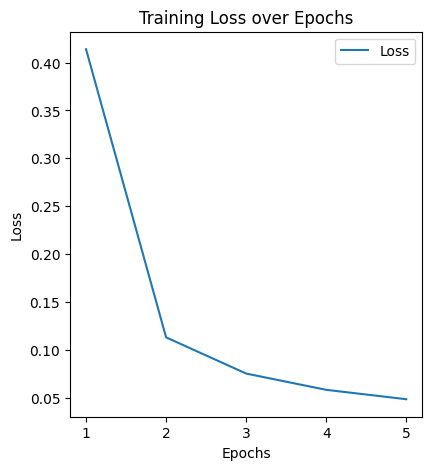

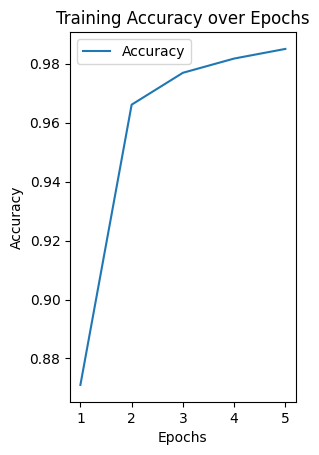

In [41]:

# Plot the loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, data["epochs"] + 1), loss_values, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.savefig('loss_plot.png')
plt.show()

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, data["epochs"] + 1), accuracy_values, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()
plt.savefig('accuracy_plot.png')
plt.show()